In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch" # alternatively you can use jax or tensorflow as the backend (see installation instructions in keras documentation)
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # helpful for splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, MinMaxScaler # helpful for scaling data to be between 0 and 1 or have a mean of 0 and standard deviation of 1


In [4]:
file_path = '/Users/ctychen/Desktop/N3AS/spectrum_data/'
#reloading data
parameters = np.concatenate([np.load(file_path + "atm_retr_params_12800_"+str(i)+".npy") for i in range(12)])
spectra_set = np.concatenate([np.load(file_path + "atm_retr_data_12800_"+str(i)+".npy") for i in range(12)])

#take the log of the spectra - seems like this helped a lot with feature identification
spectra_set = np.log(spectra_set)

parameters = parameters[~np.isnan(spectra_set).any(axis=1)]
spectra_set = spectra_set[~np.isnan(spectra_set).any(axis=1)]

print(parameters.shape)
print(spectra_set.shape)

(153590, 16)
(153590, 947)


In [30]:
n_samples = parameters.shape[0]
n_features = 947 #this is really arbitrary

# ATTEMPT 2: 
#maybe instead of using the standardscaler (or minmaxscaler), we might have to normalize the spectra on our own
#we could do the same (log(flux) - min / (max - min)) normalization that we did for the spectra
#and keep in mind that we are already working with log(flux) spectra. 
max_log_flux = np.max(spectra_set, axis=1)
min_log_flux = np.min(spectra_set, axis=1)
spectra_set = (spectra_set - min_log_flux[:, np.newaxis])/(max_log_flux - min_log_flux)[:, np.newaxis]

#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(parameters, spectra_set, test_size=0.2)

# scale data
xscaler = MinMaxScaler() #not sure if this is the best scaler to use, but just testing it out
#for the autoencoder though, we only need y, which is the spectra

# ATTEMPT 1: use the standard scaler
# yscaler = StandardScaler()

#don't actually need this for the autoencoder
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

#for the autoencoder - want to predict y with y (the spectra with themselves)
# y_train = yscaler.fit_transform(y_train)
# y_test = yscaler.transform(y_test)

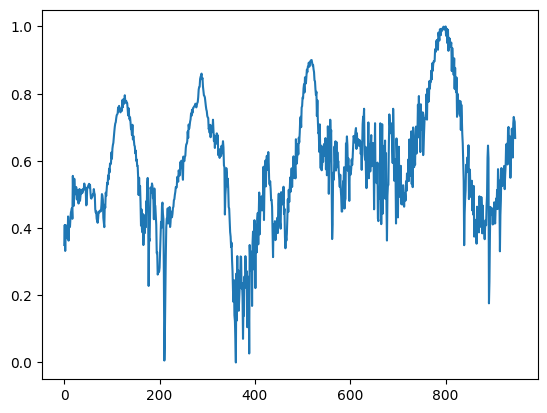

In [32]:
#plot some example training data to check
#parameters are the input, spectra are the output
# print(f'Parameters example: {X_train[0]}, length: {len(X_train[0])}')   

plt.plot(y_train[0])
plt.show()

# Experimenting with autoencoders for finding anomalous spectra 
Using the neural network example notebook as a starting point... 

In [33]:
# FROM NN EXAMPLE CODE
# create an autoencoder

#everything below may be subject to change as we try running this model
inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
x = keras.layers.Dense(64, activation="relu")(inp) # 64 neurons with relu activation function
x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
x = keras.layers.Dense(8, activation="relu")(x) # 8 neurons with relu activation function (bottleneck layer)
x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
x = keras.layers.Dense(64, activation="relu")(x) # 64 neurons with relu activation function
out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons

autoencoder = keras.models.Model(inp, out) # create model with input and output layers

# compile model
autoencoder.compile(optimizer="adam", loss="mean_squared_error") # use adam optimizer and mean squared error loss function

# print model summary
autoencoder.summary()

# train model with training data and validate with testing data (early stopping is used to avoid overfitting)
history = autoencoder.fit(y_train, y_train, epochs=500, batch_size=32, validation_data=(y_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # this stops training if the validation loss does not decrease for 5 epochs to avoid overfitting

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 947)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        60,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 947)            │        61,555 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,971 (495.98 KB)

 Trainable params: 126,971 (495.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0188 - val_loss: 0.0037
Epoch 2/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 5/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 6/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 11/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 12/500
3

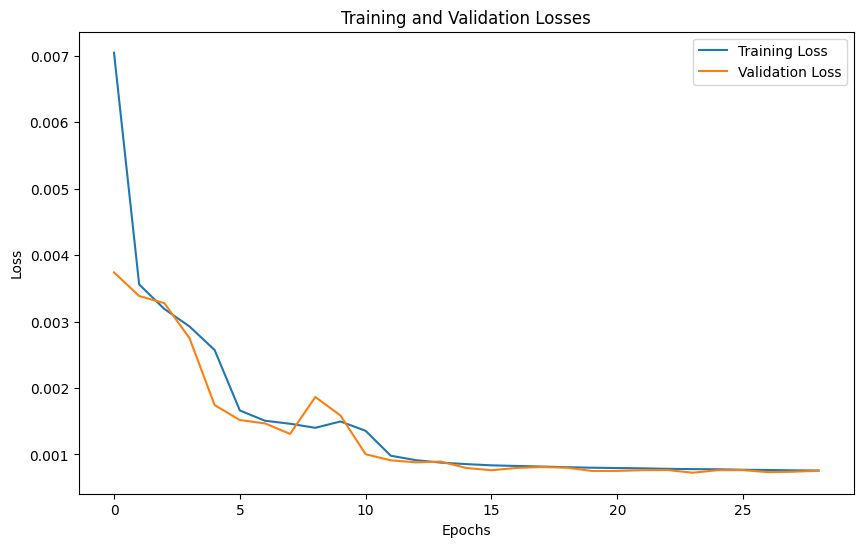

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Training and Validation Losses')
plt.legend()
plt.show()

In [35]:
#try evaluating the model with testing data
loss = autoencoder.evaluate(y_test, y_test)
print(f'Test Loss: {loss}')

960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - loss: 7.6594e-04
Test Loss: 0.0007544641848653555


960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step


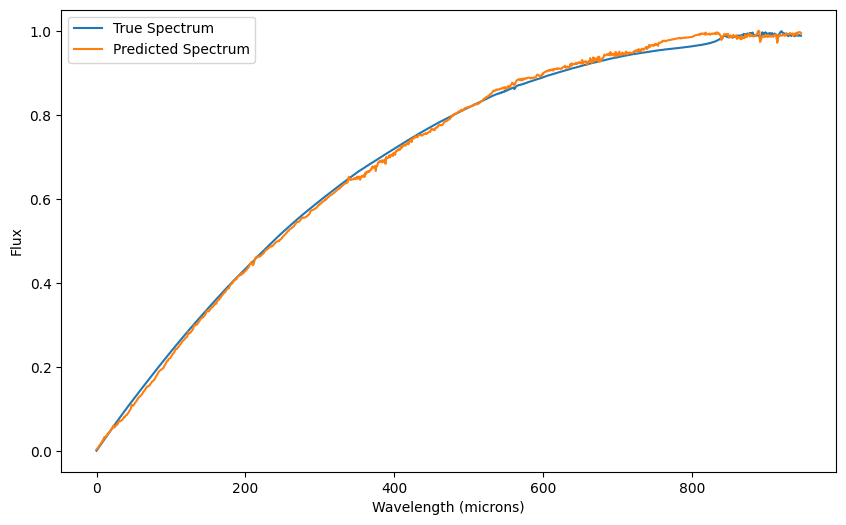

In [36]:
#example predictions
y_pred = autoencoder.predict(y_test)
# y_pred_unscaled = yscaler.inverse_transform(y_pred) 
# y_test_unscaled = yscaler.inverse_transform(y_test)

# wavelengths = np.linspace(0.95, 2.45, len(y_test_unscaled[0]))
wavelengths = np.linspace(0.95, 2.45, len(y_test[0]))

plt.figure(figsize=(10, 6))
# plt.plot(y_test_unscaled[0], label="True Spectrum")
# plt.plot(y_pred_unscaled[0], label="Predicted Spectrum")
plt.plot(y_test[0], label="True Spectrum")
plt.plot(y_pred[0], label="Predicted Spectrum")
plt.legend()
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux")
plt.show()


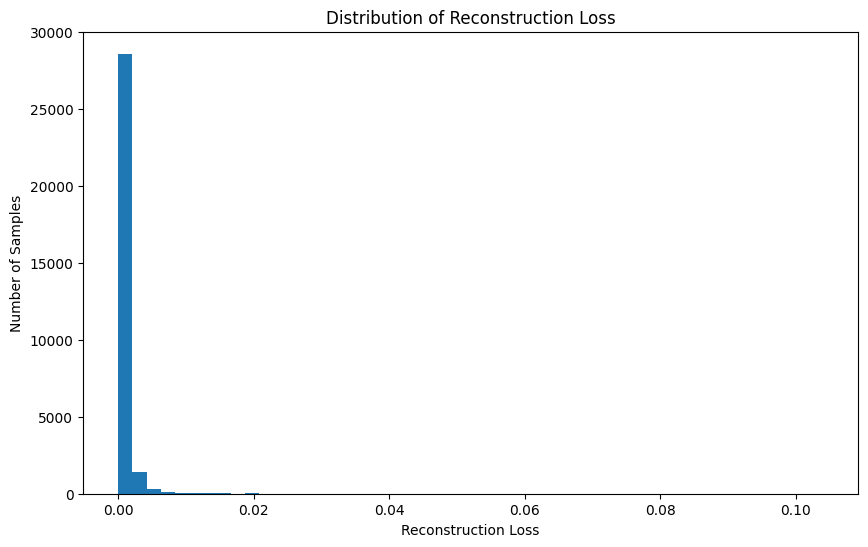

Mean Reconstruction Loss: 0.0007544713932376484
Max Reconstruction Loss: 0.10401437309617637
Min Reconstruction Loss: 2.627992164129413e-05


In [37]:
#what does the distribution of reconstruction loss look like? 
#in this case, let's find mean squared error (reconstruction loss/error) for each sample

# y_pred_unscaled = yscaler.inverse_transform(y_pred)
# y_test_unscaled = yscaler.inverse_transform(y_test)

# reconstruction_loss = np.mean((y_pred_unscaled - y_test_unscaled)**2, axis=1)

reconstruction_loss = np.mean((y_pred - y_test)**2, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Loss")
plt.show()

print(f'Mean Reconstruction Loss: {np.mean(reconstruction_loss)}')
print(f'Max Reconstruction Loss: {np.max(reconstruction_loss)}')
print(f'Min Reconstruction Loss: {np.min(reconstruction_loss)}')

[ 4166  6322 12530 15033   890  9233 26006  1408  6850 21164]


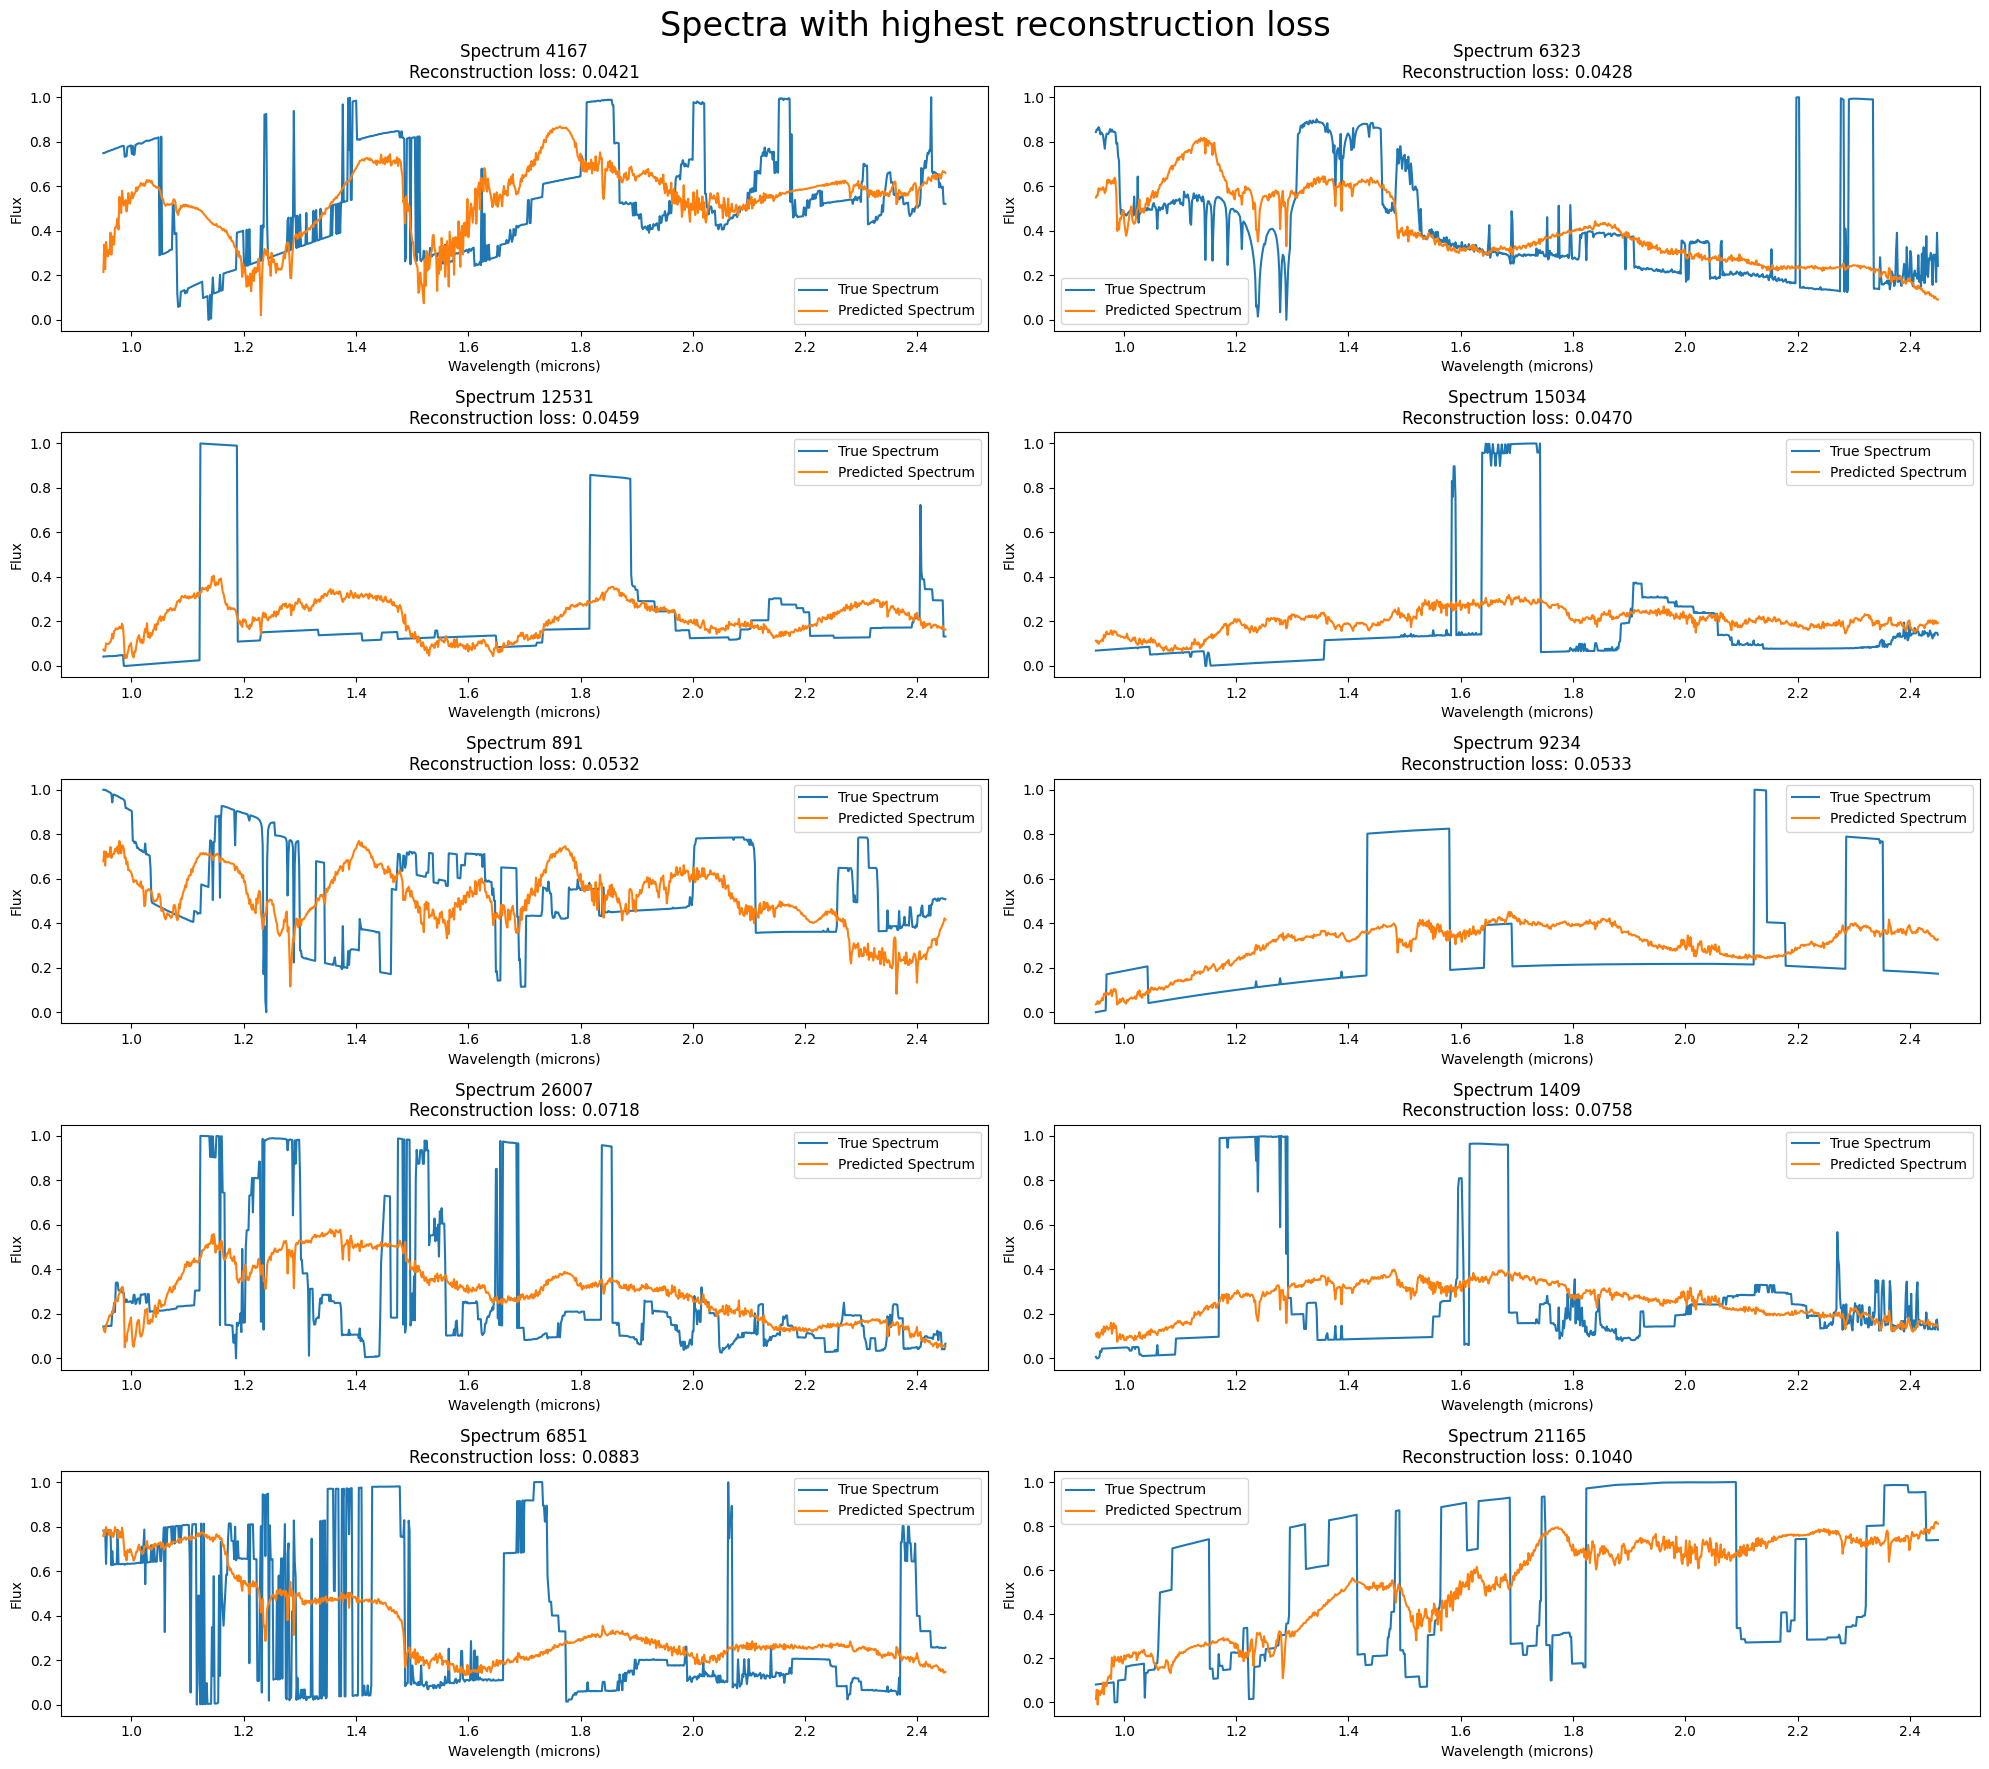

In [38]:
#what do the spectra with the worst (highest) reconstruction loss look like? 
#let's plot the 10 worst spectra... 
worst_indices = np.argsort(reconstruction_loss)[-10:]
print(worst_indices)

fig, axs = plt.subplots(5, 2, figsize=(20, 18))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    # axs[i].plot(wavelengths, y_test_unscaled[idx], label="True Spectrum")
    # axs[i].plot(wavelengths, y_pred_unscaled[idx], label="Predicted Spectrum")
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx+1}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()